# 1. Problem Definition

## Business Context:
### Customer churn (when a customer stops using a service) is a major challenge for telecom companies. Retaining existing customers is significantly cheaper than acquiring new ones. By predicting churn, companies can take proactive steps to retain at-risk customers.

## Objective:
### Build a classification model to predict customer churn (Yes/No) based on demographic, service, and account details.

## Target Variable:
### Churn → Yes (customer left) / No (customer stayed).

## Features:
### i. Demographics (gender, senior citizen, partner, dependents).

### ii. Services (phone service, internet service, streaming, support).

### iii. Account details (tenure, contract type, payment method, charges).

## Success Criteria:

### i. Model performance → High Recall for churn class + good ROC-AUC.

### ii. Business insights → Identify key drivers of churn and recommend actions.

# 2. Solution Workflow
## Data Understanding & Loading

In [93]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Loading the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
# Randomly select 10 rows
df.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1143,2446-ZKVAF,Male,0,Yes,No,18,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,No,Credit card (automatic),56.80,1074.65,No
2753,6857-VWJDT,Female,0,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Mailed check,95.65,95.65,Yes
4015,8570-KLJYJ,Female,0,No,No,36,Yes,Yes,DSL,Yes,...,No,No,No,No,One year,No,Mailed check,54.45,1893.5,No
711,7929-DMBCV,Female,0,Yes,No,20,Yes,No,Fiber optic,No,...,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,81.00,1683.7,No
6305,1597-LHYNC,Female,1,No,No,26,Yes,Yes,Fiber optic,Yes,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,95.00,2497.2,Yes
6286,2717-HVIZY,Female,0,No,Yes,8,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,163.6,No
1872,9938-PRCVK,Female,0,Yes,Yes,41,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.70,804.25,No
4465,3606-SBKRY,Male,0,No,No,31,No,No phone service,DSL,No,...,Yes,No,Yes,Yes,One year,Yes,Electronic check,50.05,1523.4,No
4197,5934-RMPOV,Female,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,1816.75,No
1539,5071-FBJFS,Female,0,Yes,Yes,4,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,No,Electronic check,50.30,217.1,No


In [6]:
# DataFrame summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
# Summary stats
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [9]:
# Check for duplicates
df.duplicated().any()

False

In [10]:
# Check for null values
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [11]:
# Fill missing values with median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

## Exploratory Data Analysis

In [13]:
# Plot settings
plt.rcParams.update({
    "figure.figsize": (10, 6),   # default figure size
    "axes.titlesize": 16,        # title font size
    "axes.labelsize": 14,        # x and y labels font size
    "xtick.labelsize": 12,       # x tick labels size
    "ytick.labelsize": 12,       # y tick labels size
    "axes.grid": True,           # show grid
    "grid.alpha": 0.3,           # grid transparency
    "legend.fontsize": 12        # legend font size
})

# Seaborn theme
sns.set_theme(style="whitegrid", palette="deep")  # seaborn style + colors

### i. Univariate Analysis

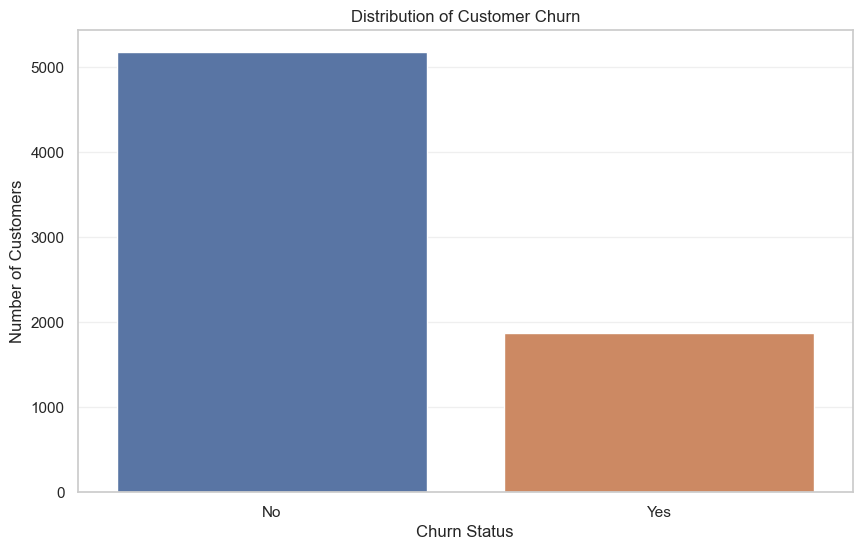


Churn Percentage:
No     73.463013
Yes    26.536987
Name: Churn, dtype: float64


In [15]:
# Plot churn distribution
sns.countplot(x='Churn', data=df)

plt.title('Distribution of Customer Churn')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.show()

# Calculate churn percentages
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print("\nChurn Percentage:")
print(churn_percentage)

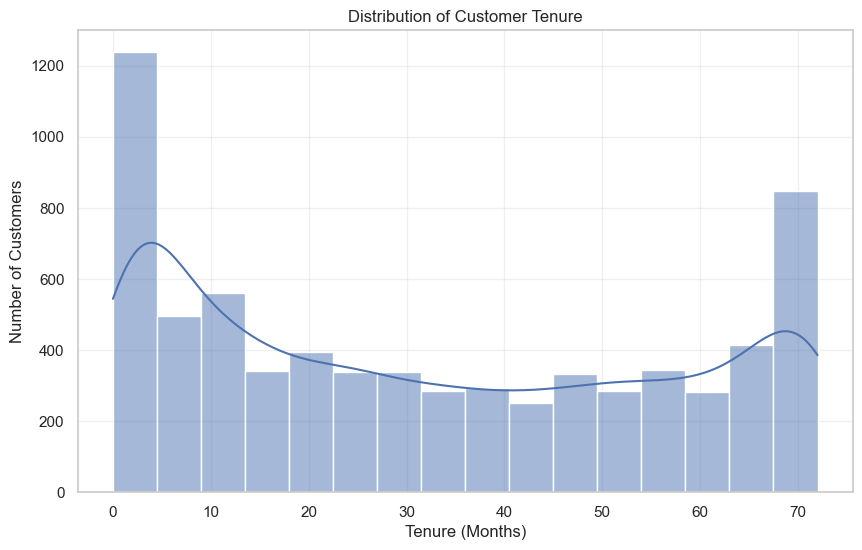

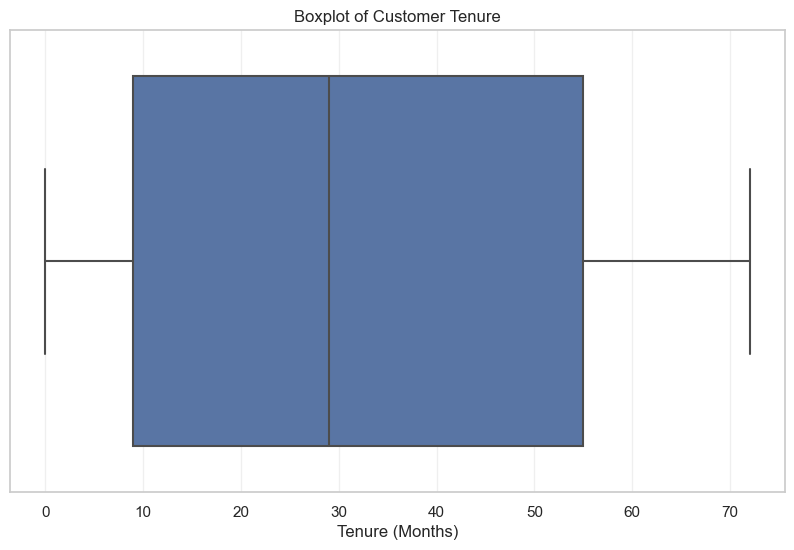

In [16]:
# Plot tenure distribution
sns.histplot(data=df, x='tenure', kde=True)
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()

# Plot tenure boxplot
sns.boxplot(x='tenure', data=df)
plt.title('Boxplot of Customer Tenure')
plt.xlabel('Tenure (Months)')
plt.show()

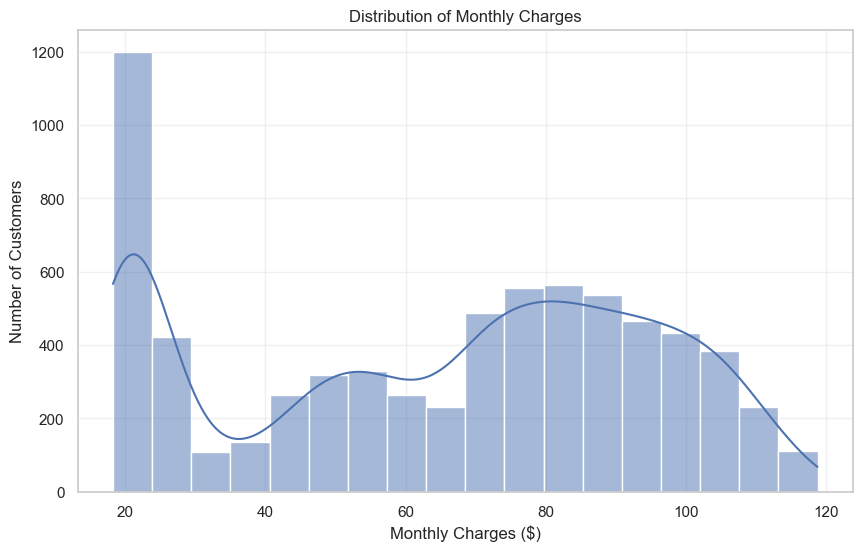

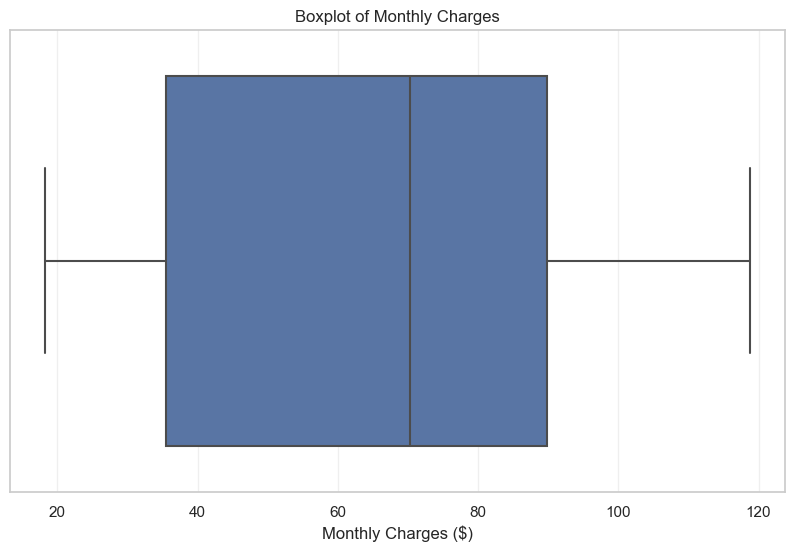

In [17]:
# Plot monthly charges distribution
sns.histplot(data=df, x='MonthlyCharges', kde=True)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Number of Customers')
plt.show()

# Plot monthly charges boxplot
sns.boxplot(x='MonthlyCharges', data=df)
plt.title('Boxplot of Monthly Charges')
plt.xlabel('Monthly Charges ($)')
plt.show()

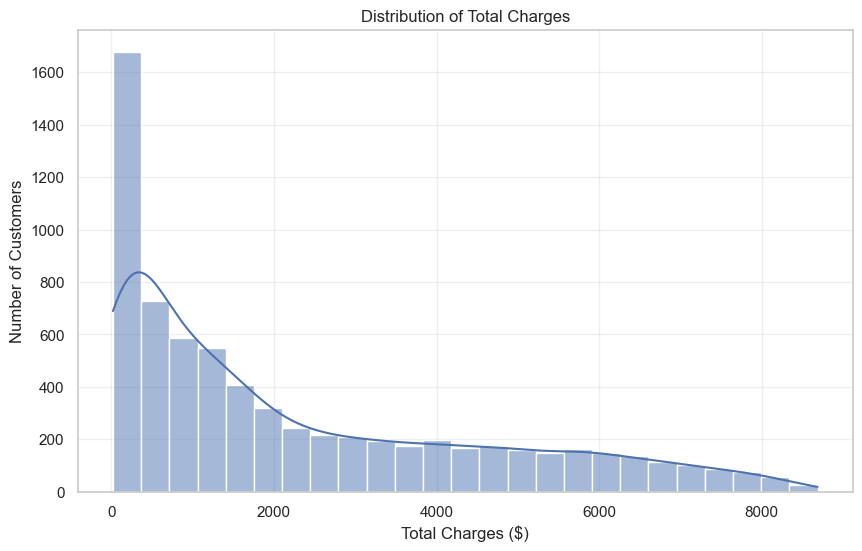

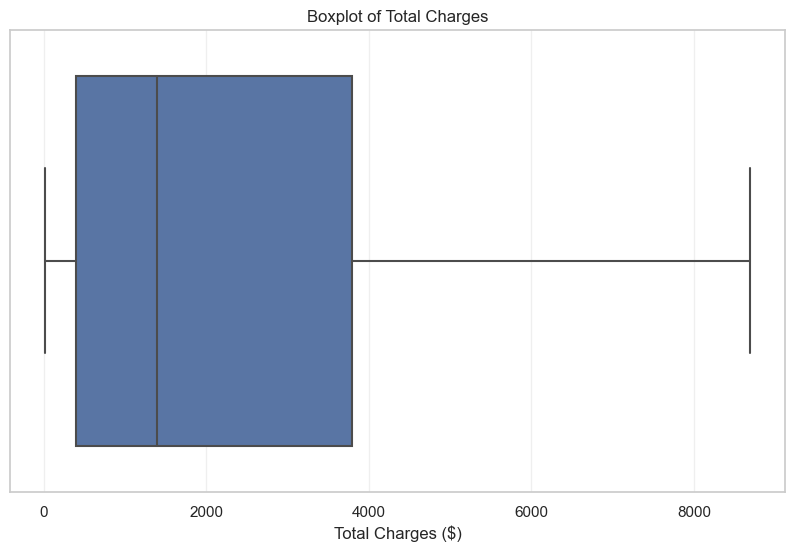

In [18]:
# Plot total charges distribution
sns.histplot(data=df, x='TotalCharges', kde=True)
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges ($)')
plt.ylabel('Number of Customers')
plt.show()

# Plot total charges boxplot
sns.boxplot(x='TotalCharges', data=df)
plt.title('Boxplot of Total Charges')
plt.xlabel('Total Charges ($)')
plt.show()

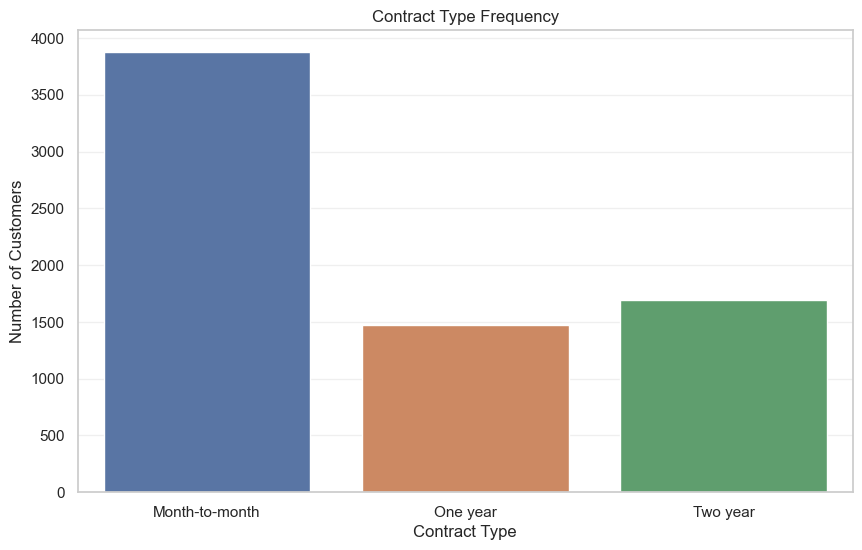

In [19]:
# Plot contract type frequency
sns.countplot(data=df, x='Contract')

plt.title('Contract Type Frequency')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()

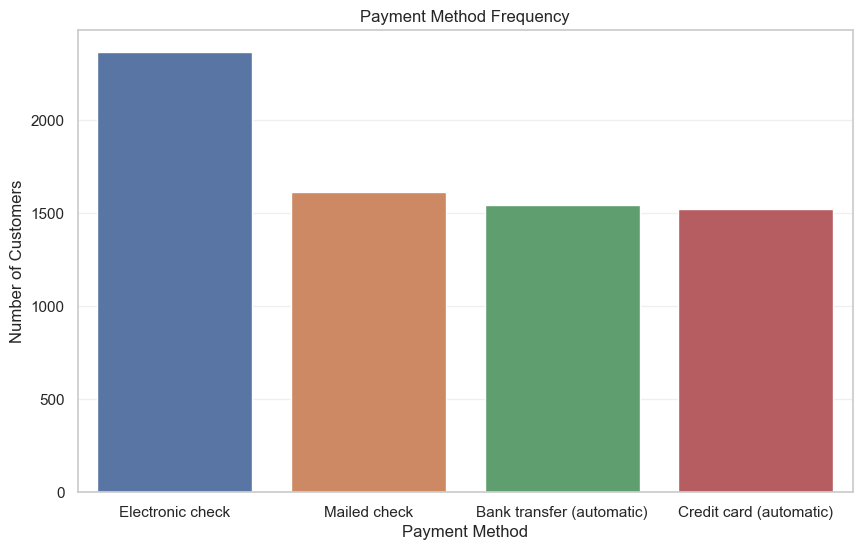

In [20]:
# Plot payment method frequency
sns.countplot(data=df, x='PaymentMethod')

plt.title('Payment Method Frequency')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.show()

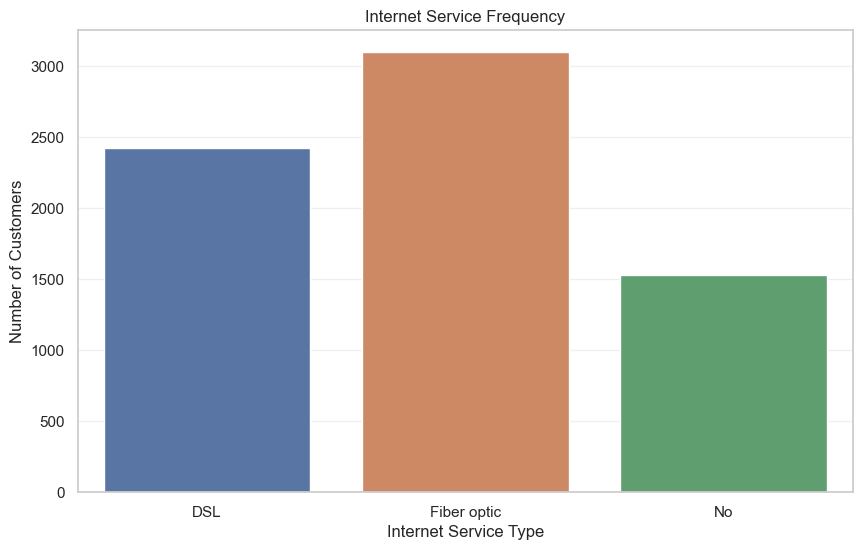

In [21]:
# Plot internet service frequency
sns.countplot(data=df, x='InternetService')

plt.title('Internet Service Frequency')
plt.xlabel('Internet Service Type')
plt.ylabel('Number of Customers')
plt.show()

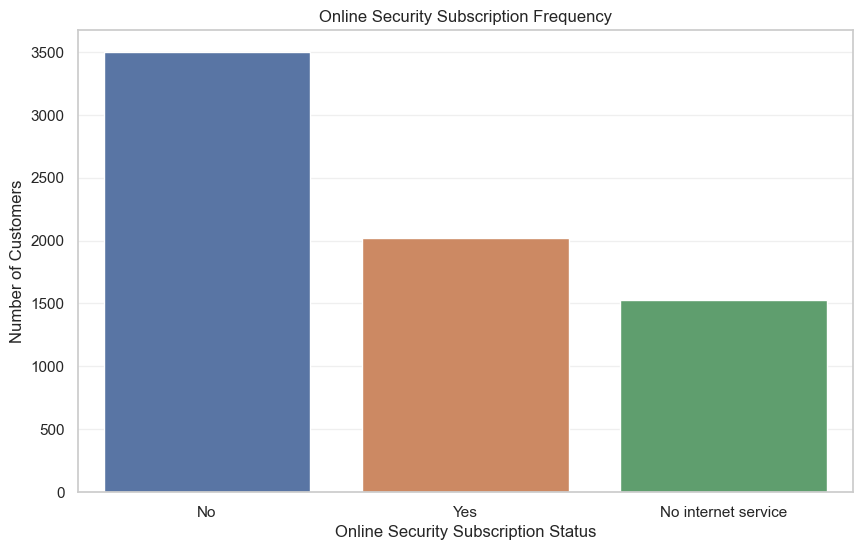

In [22]:
# Plot online security subscription frequency
sns.countplot(data=df, x='OnlineSecurity')

plt.title('Online Security Subscription Frequency')
plt.xlabel('Online Security Subscription Status')
plt.ylabel('Number of Customers')
plt.show()

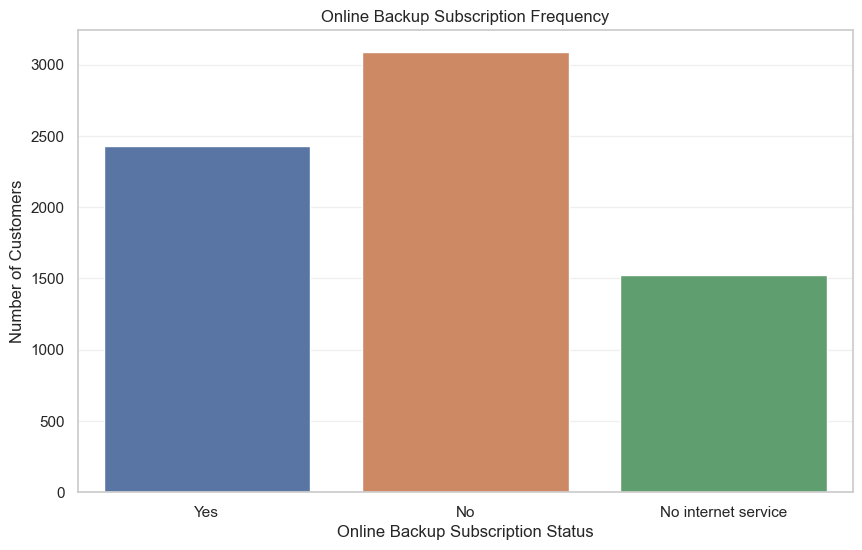

In [23]:
# Plot online backup subscription frequency
sns.countplot(data=df, x='OnlineBackup')

plt.title('Online Backup Subscription Frequency')
plt.xlabel('Online Backup Subscription Status')
plt.ylabel('Number of Customers')
plt.show()

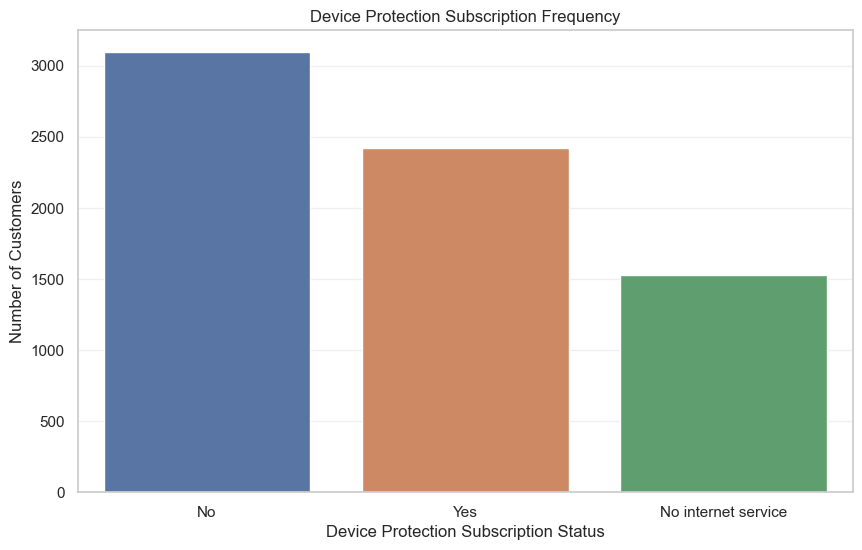

In [24]:
# Plot device protection subscription frequency
sns.countplot(data=df, x='DeviceProtection')

plt.title('Device Protection Subscription Frequency')
plt.xlabel('Device Protection Subscription Status')
plt.ylabel('Number of Customers')
plt.show()

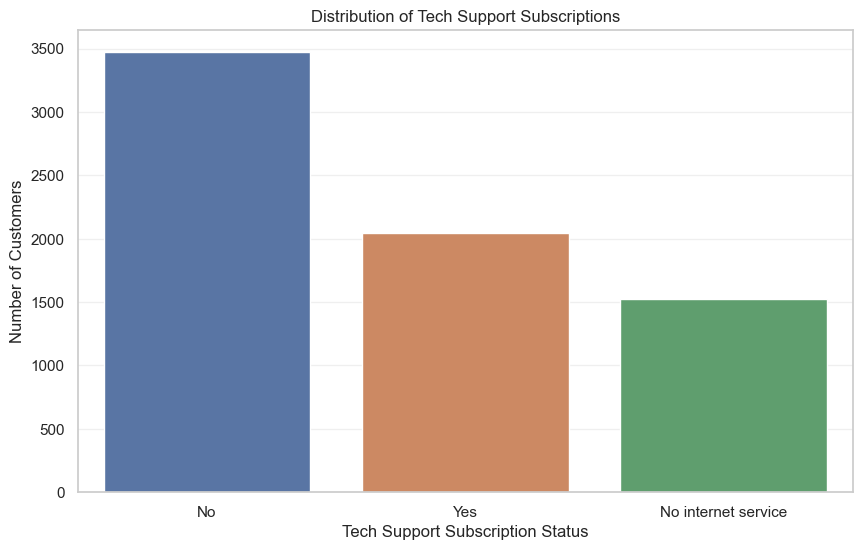

In [25]:
# Plot a count plot
sns.countplot(data=df, x='TechSupport')

plt.title('Distribution of Tech Support Subscriptions')
plt.xlabel('Tech Support Subscription Status')
plt.ylabel('Number of Customers')
plt.show()

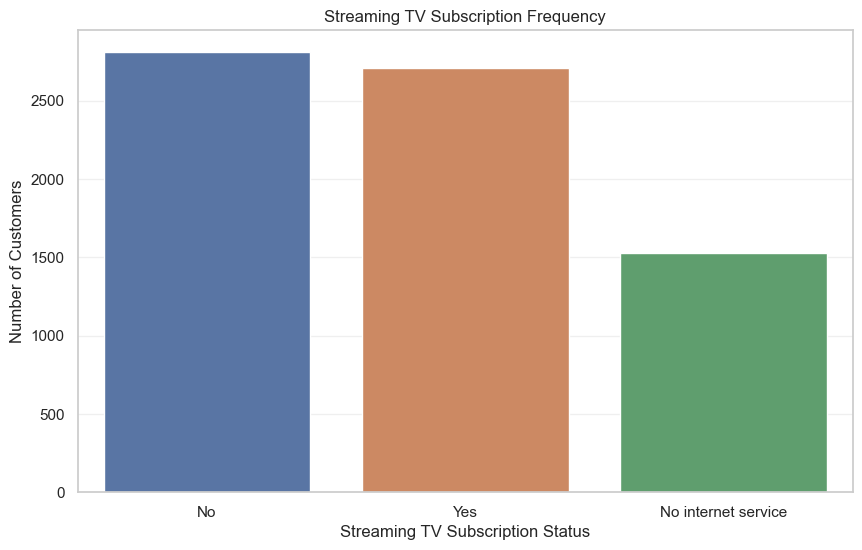

In [26]:
# Plot streaming TV subscription frequency
sns.countplot(data=df, x='StreamingTV')

plt.title('Streaming TV Subscription Frequency')
plt.xlabel('Streaming TV Subscription Status')
plt.ylabel('Number of Customers')
plt.show()

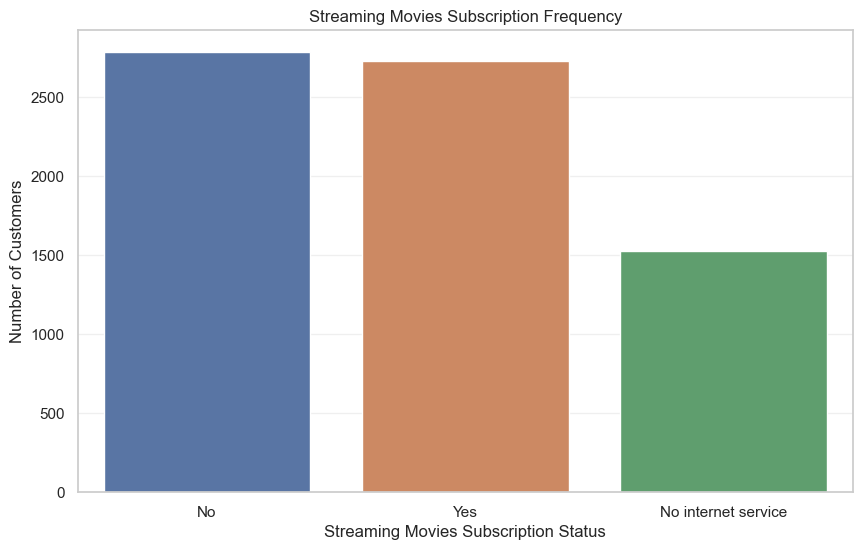

In [27]:
# Plot streaming movies subscription frequency
sns.countplot(data=df, x='StreamingMovies')

plt.title('Streaming Movies Subscription Frequency')
plt.xlabel('Streaming Movies Subscription Status')
plt.ylabel('Number of Customers')
plt.show()

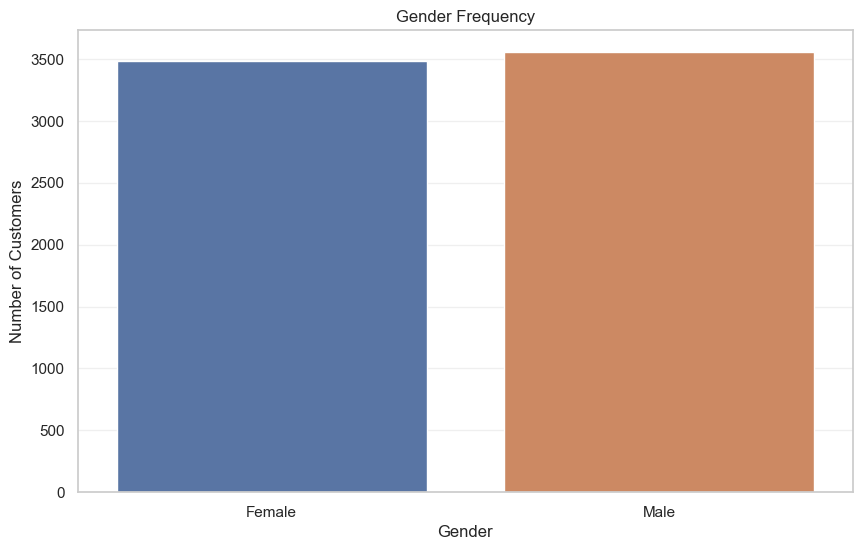

In [28]:
# Plot gender frequency
sns.countplot(data=df, x='gender')

plt.title('Gender Frequency')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.show()

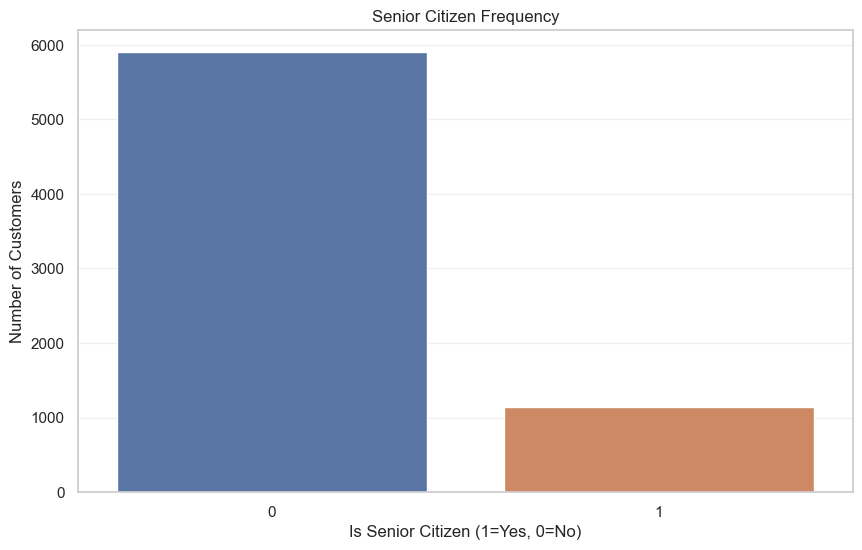

In [29]:
# Plot senior citizen frequency
sns.countplot(data=df, x='SeniorCitizen')

plt.title('Senior Citizen Frequency')
plt.xlabel('Is Senior Citizen (1=Yes, 0=No)')
plt.ylabel('Number of Customers')
plt.show()

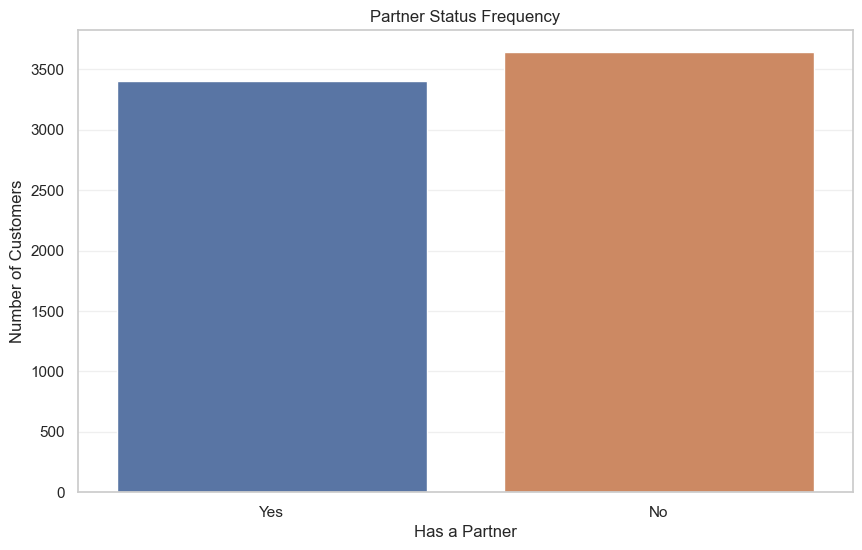

In [30]:
# Plot partner status frequency
sns.countplot(data=df, x='Partner')

plt.title('Partner Status Frequency')
plt.xlabel('Has a Partner')
plt.ylabel('Number of Customers')
plt.show()

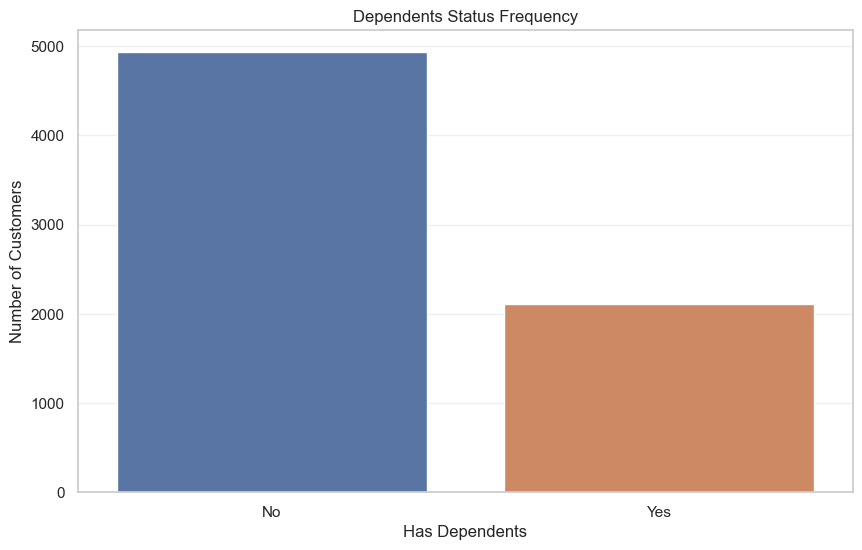

In [31]:
# Plot dependents status frequency
sns.countplot(data=df, x='Dependents')

plt.title('Dependents Status Frequency')
plt.xlabel('Has Dependents')
plt.ylabel('Number of Customers')
plt.show()

### ii. Bivariate Analysis

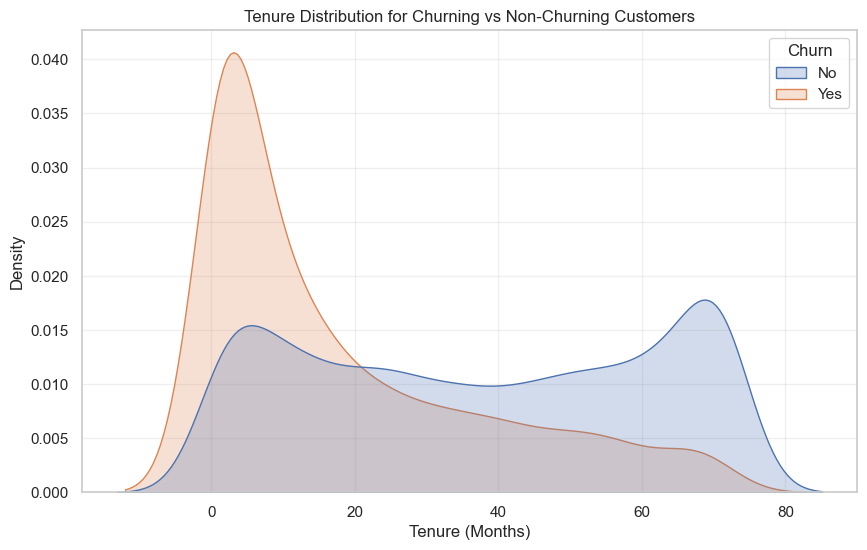

In [33]:
# KDE plot: Tenure by Churn
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False)

plt.title('Tenure Distribution for Churning vs Non-Churning Customers')
plt.xlabel('Tenure (Months)')
plt.ylabel('Density')
plt.show()

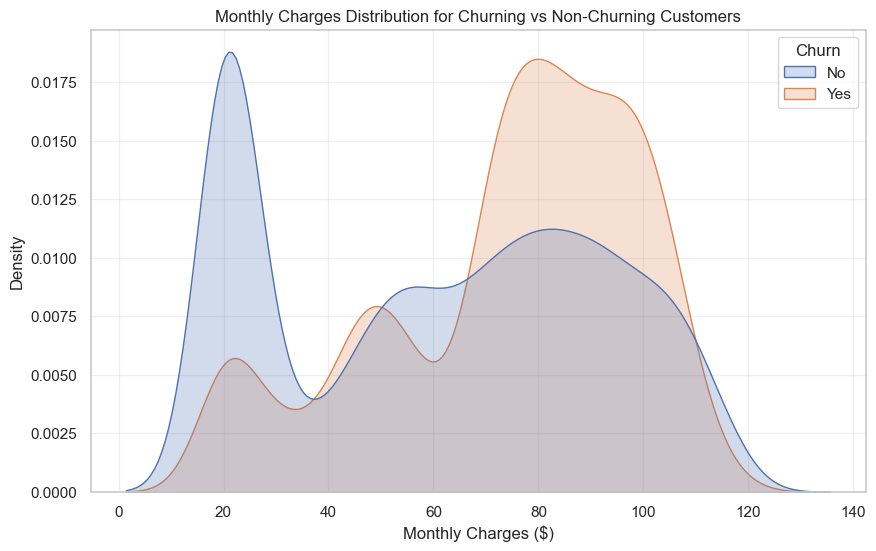

In [34]:
# KDE plot: Monthly Charges by Churn
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False)

plt.title('Monthly Charges Distribution for Churning vs Non-Churning Customers')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Density')
plt.show()

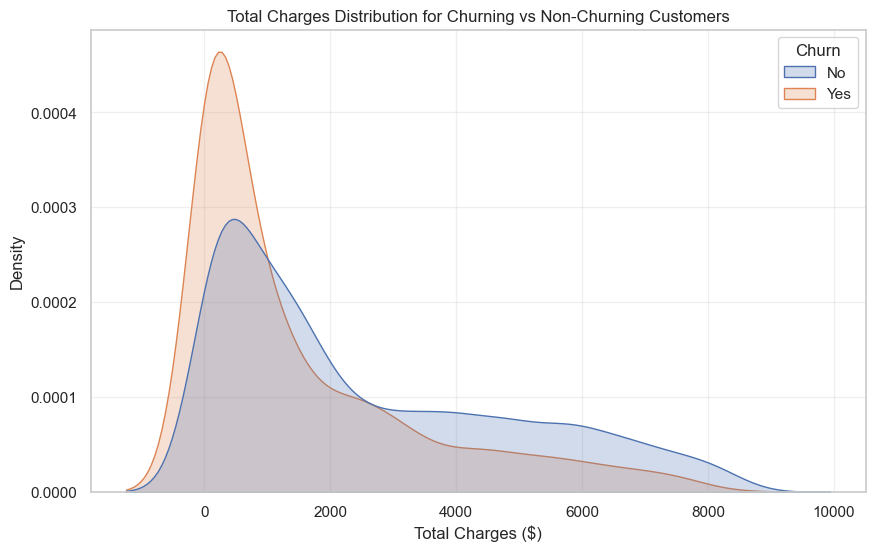

In [35]:
# KDE plot: Total Charges by Churn
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, common_norm=False)

plt.title('Total Charges Distribution for Churning vs Non-Churning Customers')
plt.xlabel('Total Charges ($)')
plt.ylabel('Density')
plt.show()

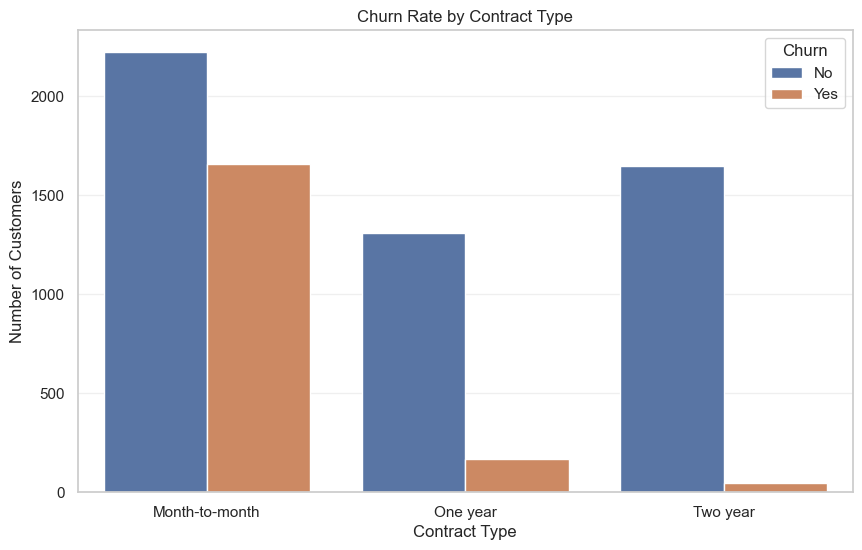

In [36]:
# Countplot: Churn by Contract Type
sns.countplot(data=df, x='Contract', hue='Churn')

plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()

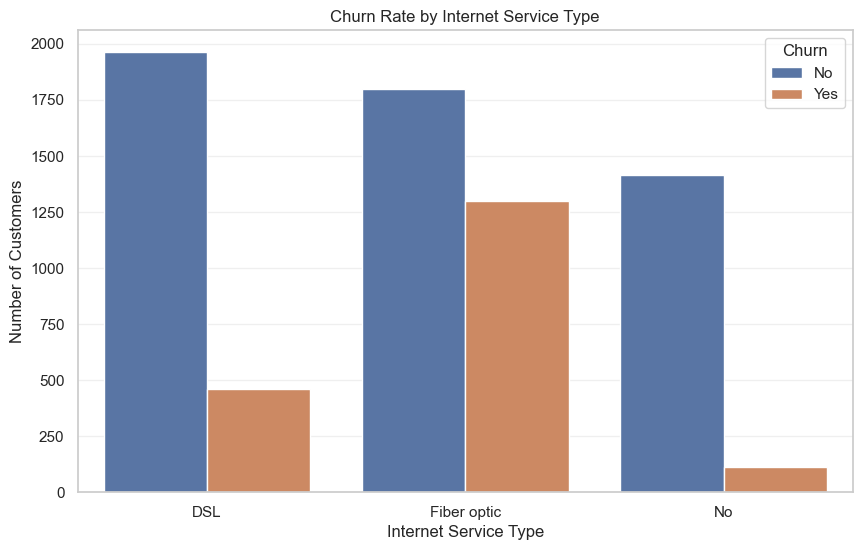

In [37]:
# Countplot: Churn by Internet Service
sns.countplot(data=df, x='InternetService', hue='Churn')

plt.title('Churn Rate by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Number of Customers')
plt.show()

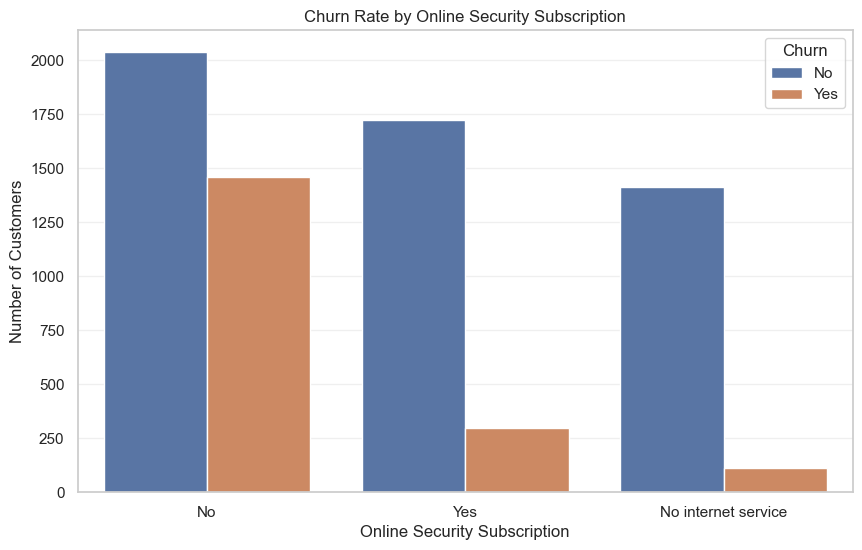

In [38]:
# Countplot: Churn by Online Security
sns.countplot(data=df, x='OnlineSecurity', hue='Churn')

plt.title('Churn Rate by Online Security Subscription')
plt.xlabel('Online Security Subscription')
plt.ylabel('Number of Customers')
plt.show()

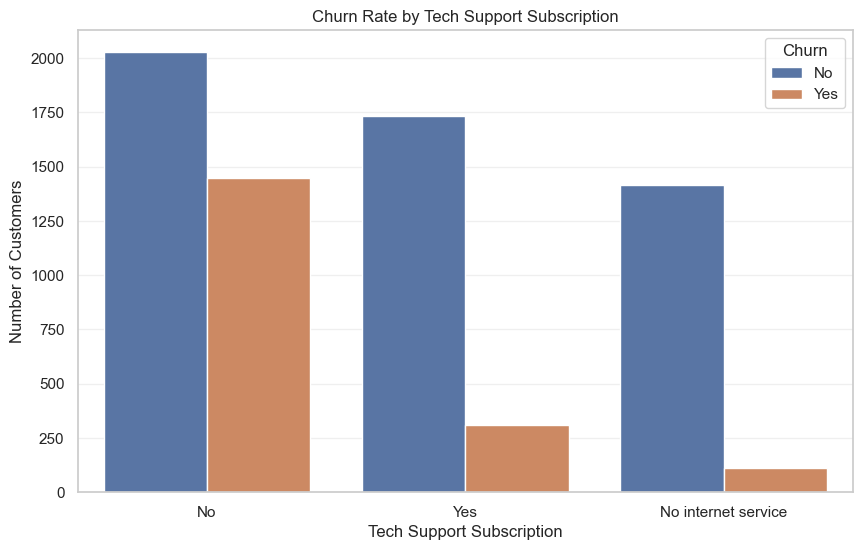

In [39]:
# Countplot: Churn by Tech Support
sns.countplot(data=df, x='TechSupport', hue='Churn')

plt.title('Churn Rate by Tech Support Subscription')
plt.xlabel('Tech Support Subscription')
plt.ylabel('Number of Customers')
plt.show()

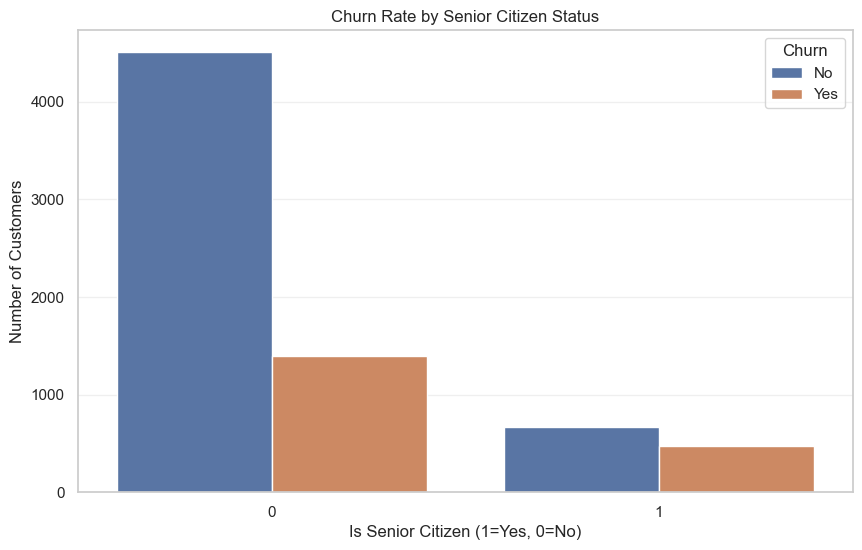

In [40]:
# Countplot: Churn by Senior Citizen
sns.countplot(data=df, x='SeniorCitizen', hue='Churn')

plt.title('Churn Rate by Senior Citizen Status')
plt.xlabel('Is Senior Citizen (1=Yes, 0=No)')
plt.ylabel('Number of Customers')
plt.show()

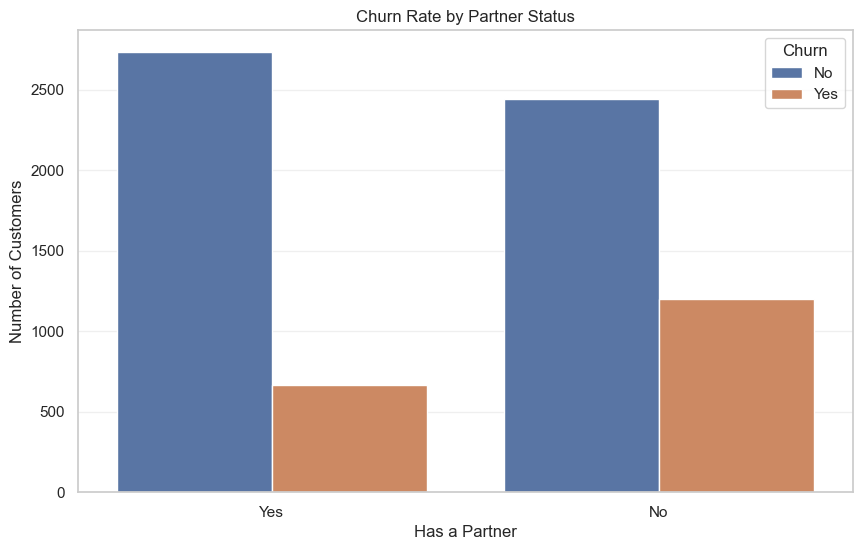

In [41]:
# Countplot: Churn by Partner
sns.countplot(data=df, x='Partner', hue='Churn')

plt.title('Churn Rate by Partner Status')
plt.xlabel('Has a Partner')
plt.ylabel('Number of Customers')
plt.show()

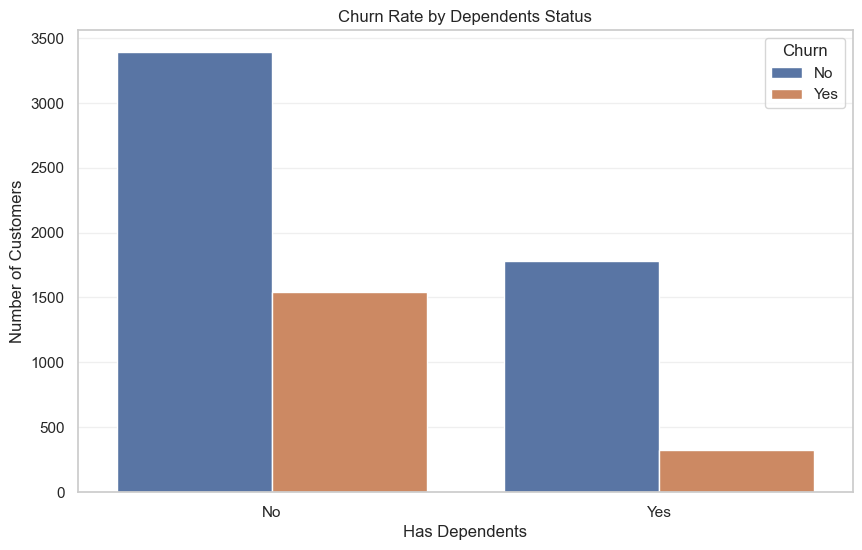

In [42]:
# Countplot: Churn by Dependents
sns.countplot(data=df, x='Dependents', hue='Churn')

plt.title('Churn Rate by Dependents Status')
plt.xlabel('Has Dependents')
plt.ylabel('Number of Customers')
plt.show()

### iii. Correlation Analysis

In [44]:
# Convert Churn to numeric (Yes=1, No=0)
df['Churn_numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

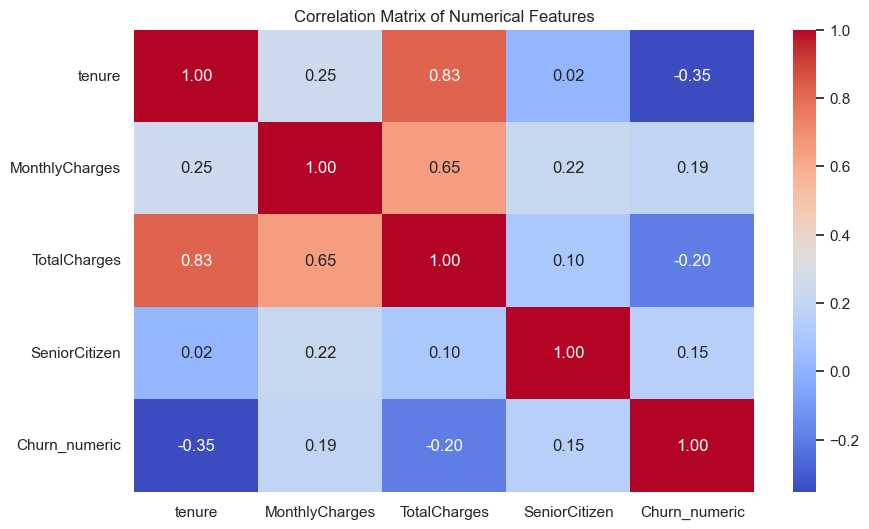

In [45]:
# Select numerical columns for correlation
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Churn_numeric']
correlation_matrix = df[numerical_cols].corr()

# Plot correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Data Preprocessing

In [47]:
# Drop non-predictive columns
df = df.drop('customerID', axis=1)  # ID column not useful for prediction
df = df.drop('Churn_numeric', axis=1)  # Temporary numeric target column

In [48]:
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [49]:
# Separate features and target
X = df.drop('Churn', axis=1)  # Features
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)  # Encode target as 0/1

In [51]:
# Define Numerical and Categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocess numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numeric features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)  # Encode categorical features
    ],
    remainder='passthrough'  # Keep other columns as-is
)

# Apply preprocessing to features
X_processed = preprocessor.fit_transform(X)

In [53]:
# Split the processed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed,       # Features after preprocessing
    y,                 # Target variable
    test_size=0.2,     # 20% test, 80% train
    random_state=42,   # Ensures reproducibility
    stratify=y         # Maintain same class distribution in train and test
)

In [55]:
# Balance the training data using SMOTE 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [95]:
# Initialize models
log_reg = LogisticRegression(random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)
rand_forest = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train models on balanced training data
log_reg.fit(X_train_resampled, y_train_resampled)
dec_tree.fit(X_train_resampled, y_train_resampled)
rand_forest.fit(X_train_resampled, y_train_resampled)
xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



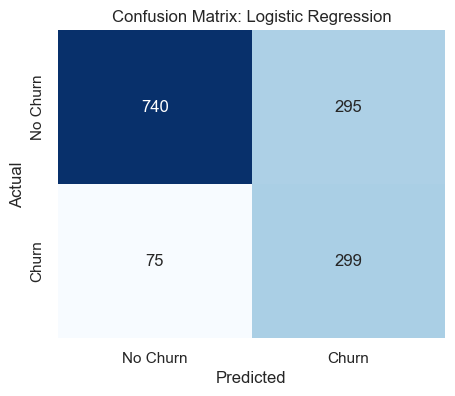

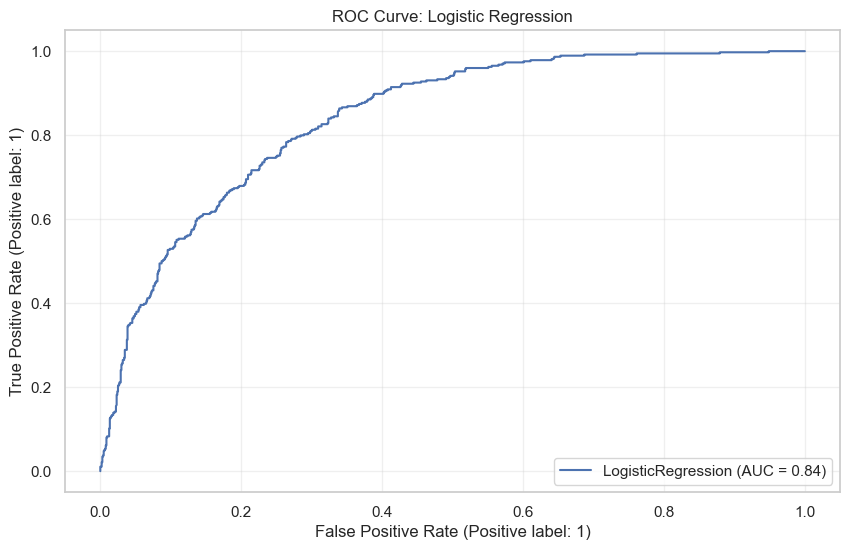


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1035
           1       0.47      0.53      0.50       374

    accuracy                           0.71      1409
   macro avg       0.64      0.66      0.65      1409
weighted avg       0.73      0.71      0.72      1409



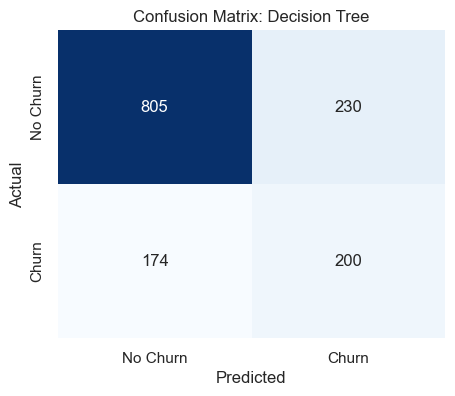

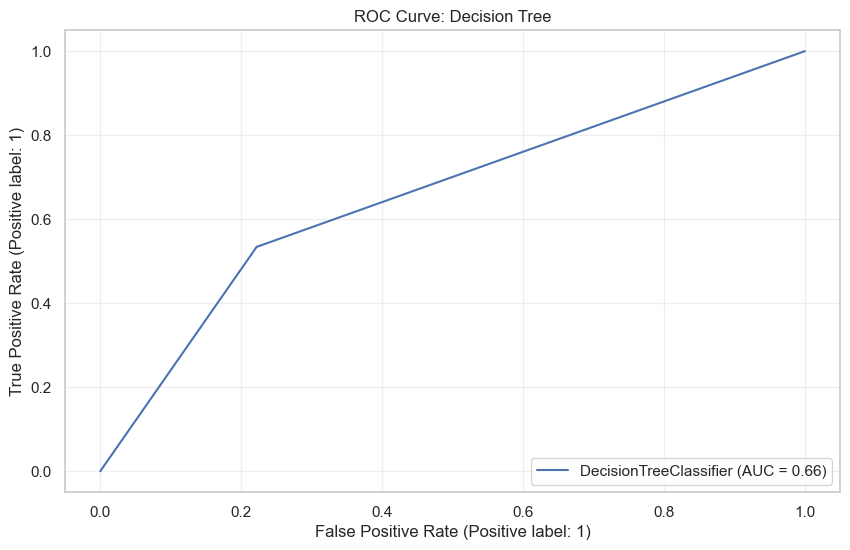


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.59      0.57      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409



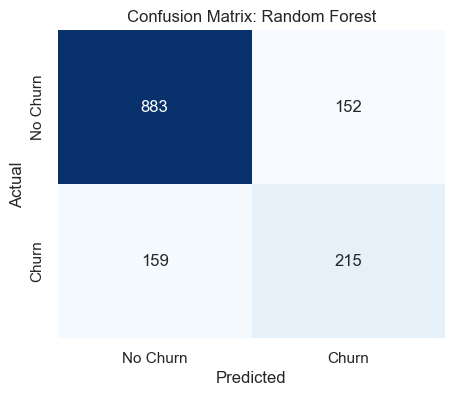

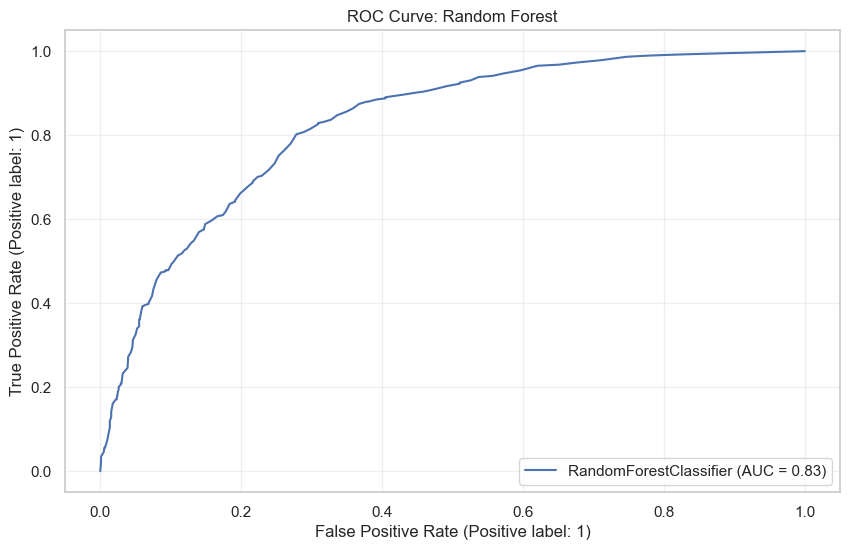


--- XGBoost ---
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.58      0.61      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409



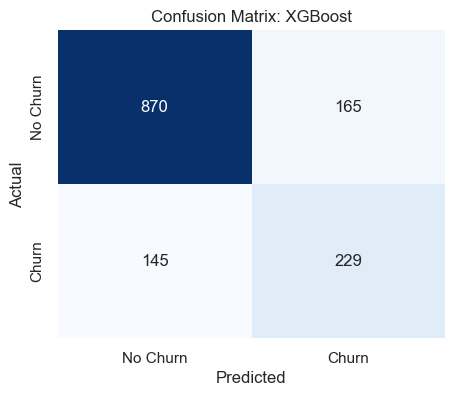

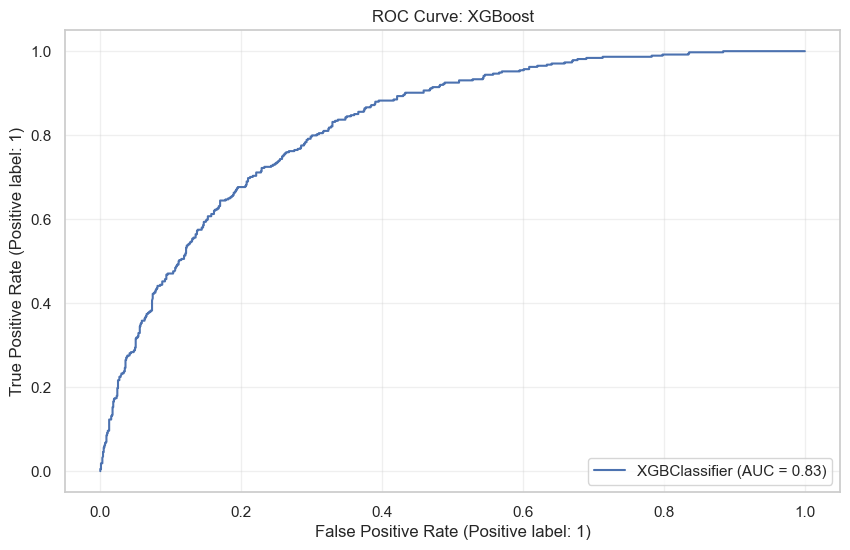

In [71]:
# Put all models in a dictionary
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dec_tree,
    "Random Forest": rand_forest,
    "XGBoost": xgb
}
for name, model in models.items():
    print(f"\n{name}")
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Classification Report
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Churn", "Churn"],
                yticklabels=["No Churn", "Churn"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve: {name}")
    plt.show()

In [97]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='f1',        
    n_jobs=-1,           
    verbose=2
)

# Fit on training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters & score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Final tuned model
best_xgb = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.8398843045527269


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409



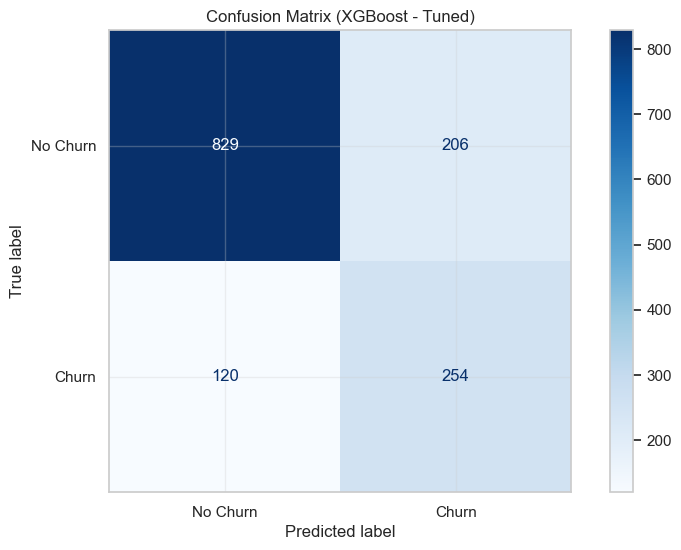

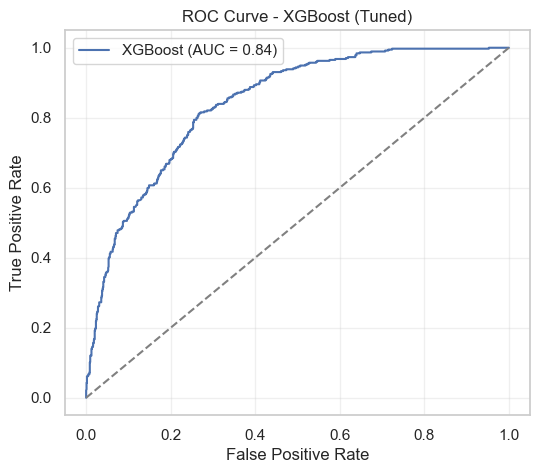

In [89]:
# Predict on test data
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (XGBoost - Tuned)")
plt.show()

# ROC Curve 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Tuned)')
plt.legend()
plt.show()

# Conclusion

## Performance Improvement:
### Our hyperparameter tuning efforts paid off, the model’s F1-score increased from 0.55 to 0.58. While the improvement might look small, it’s meaningful in practice, as it reflects a more balanced model that’s better at identifying potential churners without generating too many false alarms.

## Model Insights:
### The final confusion matrix shows that the model accurately predicted churn for 205 customers, but missed 168 actual churners and incorrectly flagged 128 loyal customers as potential churners. Depending on how the business weighs the cost of false positives versus false negatives, we can fine-tune the prediction threshold to better align with operational priorities.

## Final Recommendation:
### The tuned XGBoost model stands out as our most effective version, achieving around 80% accuracy and performing well at spotting customers likely to leave. We recommend saving and deploying this model to score new customer data, helping the business take proactive steps, such as targeted retention offers to strengthen customer loyalty and reduce churn.